In [1]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

**LOADING AND PREPROCESSING THE DATASET**

In [2]:
# Load the dataset
data_path = "/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt"
data = pd.read_csv(data_path, sep = ";", low_memory = False, na_values=['nan', '?'])

# Combine 'Date' and 'Time' into a single datetime column
data['dt'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Drop the original 'Date' and 'Time' columns
data.drop(columns=['Date', 'Time'], inplace=True)

# Set 'dt' as the index
data.set_index('dt', inplace=True)

# Display the first few rows to confirm the result
print(data.head())

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

In [3]:
# Print data columns
print(data.columns)

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')


We care only about the values of "Global_active_power".
We also drop columns with NaN values

In [4]:
# Check NaN columns
data.dropna(inplace = True)
columns = ["Global_active_power"]

To make the process smoother, we use the MinMaxScaler method. We do not use the Normalizer as it may shrinkage the form of the original dataset

In [5]:
scaler = MinMaxScaler()
data[columns] = scaler.fit_transform(data[columns])

We define the function to convert the orginal dataset to be the time series dataset

In [6]:
# Convert to sequences for time series modeling
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length,0])
    return np.array(X), np.array(y)

seq_length = 10  # Number of time steps in each sequence
X, y = create_sequences(data[columns].values, seq_length)

print(f"Sequences shape: {X.shape}, Targets shape: {y.shape}")

Sequences shape: (2049270, 10, 1), Targets shape: (2049270,)


Convert the time series sequences to Tensor to feed the LSTM Network

In [7]:
def numpy_to_tensor(X, y):
    X_tensor = torch.tensor(X, dtype = torch.float32)
    y_tensor = torch.tensor(y, dtype = torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    return dataset

batch_size = 256
dataset = numpy_to_tensor(X, y)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

**DEFINE THE LSTM NETWORK**

We define the cell of LSTM

In [8]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # Linear layers for input-to-hidden and hidden-to-hidden transformations
        self.input_to_hidden = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size * 4, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        # Initialize the parameters by uniform distribution
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hidden_state_tuple=None):
        # If hidden state is not provided, initialize it to zeros (the first time step)
        if hidden_state_tuple is None:
            hidden_state_tuple = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hidden_state_tuple = (hidden_state_tuple, hidden_state_tuple)

        hidden_state_tuple, cell_state_prev = hidden_state_tuple

        # Compute gates
        # TODO: Should we use a single linear layer and split the output? (for efficiency). Or create separate weights for each gate?
        gates = self.input_to_hidden(input) + self.hidden_to_hidden(hidden_state_tuple)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, dim=1)

        # Apply nonlinearities
        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh(cell_gate)
        o_t = torch.sigmoid(output_gate)

        # Update cell state and hidden state
        # k_t = f_t * cell_state_prev
        # j_t = i_t * g_t
        cell_state_next = f_t * cell_state_prev + i_t * g_t
        hidden_state_next = o_t * torch.tanh(cell_state_next)

        return hidden_state_next, cell_state_next

We define the LSTM Model

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Create LSTM layers
        self.rnn_cell_list = nn.ModuleList([
            LSTMCell(input_size if i == 0 else hidden_size, hidden_size, bias)
            for i in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(self.num_layers, input.size(0), self.hidden_size)
        hidden = [(hx[layer, :, :], hx[layer, :, :]) for layer in range(self.num_layers)]
        outputs = []

        for t in range(input.size(1)):
            for layer in range(self.num_layers):
                hidden[layer] = self.rnn_cell_list[layer](
                    input[:, t, :] if layer == 0 else hidden[layer - 1][0], hidden[layer]
                )
            outputs.append(hidden[-1][0])

        out = self.fc(outputs[-1].squeeze(1))
        return out

**TRAIN THE MODEL**

In [10]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in tqdm.tqdm(dataloader):
            optimizer.zero_grad()
            # Forward pass
            output = model(X_batch.to(model.fc.weight.device))
            loss = criterion(output.squeeze(), y_batch.to(model.fc.weight.device))
            # Backward pass
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

def evaluate_model(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X, dtype=torch.float32, device=model.fc.weight.device)).cpu().squeeze().numpy()
    return predictions

In [11]:
input_size = len(columns)
hidden_size = 32
num_layers = 2
output_size = 1
bias = True
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [12]:
lstm = LSTM(input_size, hidden_size, num_layers, bias, output_size).to(device)

In [13]:
nums_epochs = 3
train_model(lstm, dataloader, epochs=nums_epochs)
lstm_predictions = evaluate_model(lstm, X)

100%|██████████| 8005/8005 [02:02<00:00, 65.29it/s]


Epoch 1/3, Loss: 0.0007


100%|██████████| 8005/8005 [02:02<00:00, 65.33it/s]


Epoch 2/3, Loss: 0.0006


100%|██████████| 8005/8005 [02:01<00:00, 65.70it/s]


Epoch 3/3, Loss: 0.0006


Plotting

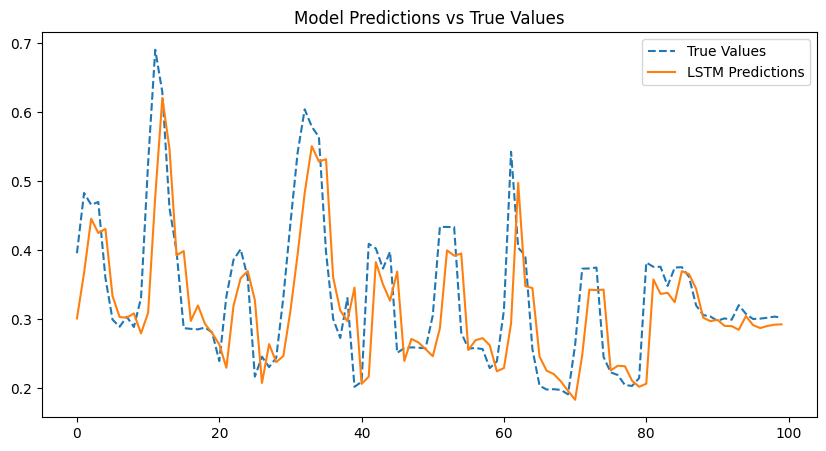

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(y[:100], label='True Values', linestyle='dashed')
plt.plot(lstm_predictions[:100], label='LSTM Predictions')
plt.legend()
plt.title("Model Predictions vs True Values")
plt.show()

**TRAIN MODEL WITH PREVIOUS OUTPUT**

In [15]:
def train_model_with_recursive_input(model, dataloader, seq_length, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in tqdm.tqdm(dataloader):
            optimizer.zero_grad()
            # Initialize the input sequence with the first sequence in the batch
            input_seq = X_batch[:, :seq_length, :].to(model.fc.weight.device)
            outputs = []
            for _ in range(0, seq_length, X_batch.size(1)):
                output = model(input_seq)
                outputs.append(output)
                new_input = torch.cat((input_seq[:, 1:, :], output.unsqueeze(1)), dim=1)
                input_seq = new_input
            
            outputs = torch.cat(outputs, dim=1)
            loss = criterion(outputs.squeeze(), y_batch.to(model.fc.weight.device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")
        
def evaluate_model_recursive(model, X, seq_length):
    model.eval()
    predictions = []
    with torch.no_grad():
        input_seq = torch.tensor(X[0], dtype=torch.float32, device=model.fc.weight.device).unsqueeze(0)
        for _ in range(len(X)):
            output = model(input_seq)
            predictions.append(output.cpu().squeeze().numpy())
            new_input = torch.cat((input_seq[:, 1:, :], output.unsqueeze(1)), dim=1)
            input_seq = new_input
    return np.array(predictions).flatten()

In [16]:
lstm = LSTM(input_size, hidden_size, num_layers, bias, output_size).to(device)

In [17]:
train_model_with_recursive_input(lstm, dataloader, seq_length, epochs=nums_epochs)

100%|██████████| 8005/8005 [02:01<00:00, 65.97it/s]


Epoch 1/3, Loss: 0.0008


100%|██████████| 8005/8005 [02:01<00:00, 65.87it/s]


Epoch 2/3, Loss: 0.0006


100%|██████████| 8005/8005 [02:01<00:00, 65.92it/s]

Epoch 3/3, Loss: 0.0006


In [18]:
numbers_to_predict = 100
lstm_recursive_predictions = evaluate_model_recursive(lstm, X[:numbers_to_predict], seq_length)

Plotting

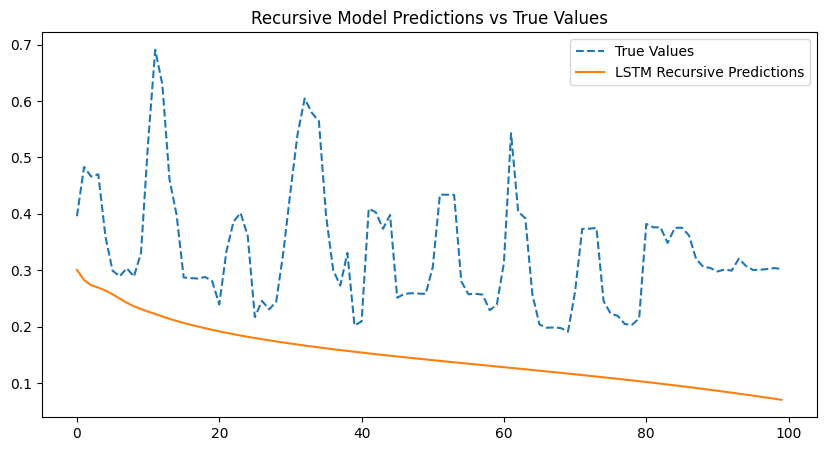

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(y[:numbers_to_predict], label='True Values', linestyle='dashed')
plt.plot(lstm_recursive_predictions[:numbers_to_predict], label='LSTM Recursive Predictions')
plt.legend()
plt.title("Recursive Model Predictions vs True Values")
plt.show()